In [1]:
from IPython import get_ipython


def type_of_script():
    """
    Detects and returns the type of python kernel
    :return: string 'jupyter' or 'ipython' or 'terminal'
    """
    try:
        ipy_str = str(type(get_ipython()))
        if 'zmqshell' in ipy_str:
            return 'jupyter'
        if 'terminal' in ipy_str:
            return 'ipython'
    except:
        return 'terminal'


if type_of_script() == 'jupyter':
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm
    
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec
import cmasher as cmr

import numpy as np
import os, glob, atexit, signal
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=0
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle, ax_change_color
from importlib import reload
from copy import deepcopy
from multiprocessing import Pool, shared_memory, Value
from common_func import *

In [2]:
mode1 = 'nh'
database1 = f"/home/jeon/MissingSat/database/{mode1}"
iout1 = 1026
repo1, rurmode1, dp1 = mode2repo(mode1)
snap1 = uri.RamsesSnapshot(repo1, iout1, mode=rurmode1)
snap1s = uri.TimeSeries(snap1)
snap1s.read_iout_avail()
nout1 = snap1s.iout_avail['iout']; nout=nout1[nout1 <= iout1]
gals1 = uhmi.HaloMaker.load(snap1, galaxy=True, double_precision=dp1)
hals1 = uhmi.HaloMaker.load(snap1, galaxy=False, double_precision=dp1)

LG1 = pklload(f"{database1}/LocalGroup.pickle")
allsats1 = None; allsubs1 = None; states1 = None
keys1 = list(LG1.keys())
for key in keys1:
    sats = LG1[key]['sats']; subs = LG1[key]['subs']; real = LG1[key]['real']
    dink = real[real['state']=='dink']['hid']
    ind = isin(subs['id'], dink)
    subs['dink'][ind] = True; subs['dink'][~ind] = False
    state = np.zeros(len(subs), dtype='<U7')
    state[ind] = 'dink'; state[~ind] = 'pair'
    
    upair = real[real['state']=='upair']['hid']
    ind = isin(subs['id'], upair)
    state[ind] = 'upair'

    allsats1 = sats if allsats1 is None else np.hstack((allsats1, sats))
    allsubs1 = subs if allsubs1 is None else np.hstack((allsubs1, subs))
    states1 = state if states1 is None else np.hstack((states1, state))
argsort = np.argsort(allsubs1['id'])
allsubs1 = allsubs1[argsort]; states1 = states1[argsort]
dinks1 = allsubs1[states1 == 'dink']
pairs1 = allsubs1[states1 == 'pair']
upairs1 = allsubs1[states1 == 'upair']

print(len(allsubs1), np.unique(states1, return_counts=True))  

1336 (array(['dink', 'pair', 'upair'], dtype='<U7'), array([1145,  130,   61]))


In [9]:
stree1 = pklload(f"{database1}/stable_tree_new.pickle")
print(stree1[list(stree1.keys())[0]].dtype.names)

('nparts', 'id', 'timestep', 'level', 'host', 'hostsub', 'nbsub', 'nextsub', 'aexp', 'm', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Lx', 'Ly', 'Lz', 'r', 'a', 'b', 'c', 'ek', 'ep', 'et', 'spin', 'sigma', 'rvir', 'mvir', 'tvir', 'cvel', 'rho0', 'rc', 'mcontam', 'r10_mem', 'r50_mem', 'r90_mem', 'r10_vir', 'r50_vir', 'r90_vir', 'r10_max', 'r50_max', 'r90_max', 'sub', 'dink', 'mdm', 'mstar', 'mcold', 'mcell', 'Host', 'r200kpc', 'm200', 'r200', 'mdm_vir', 'mstar_vir', 'mcell_vir', 'mcold_vir', 'lastid', 'give_score', 'take_score', 'insitu', 'insitu_vir')


In [4]:
pair = np.random.choice(pairs1)
# pair = pairs1[pairs1['id'] == 21103][0]
branch = stree1[pair['id']]

In [5]:
branch.dtype

dtype([('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('mcontam', '<f8'), ('r10_mem', '<f8'), ('r50_mem', '<f8'), ('r90_mem', '<f8'), ('r10_vir', '<f8'), ('r50_vir', '<f8'), ('r90_vir', '<f8'), ('r10_max', '<f8'), ('r50_max', '<f8'), ('r90_max', '<f8'), ('sub', '<i8'), ('dink', '?'), ('mdm', '<f8'), ('mstar', '<f8'), ('mcold', '<f8'), ('mcell', '<f8'), ('Host', '<i4'), ('r200kpc', '<f8'), ('m200', '<f8'), ('r200', '<f8'), ('mdm_vir', '<f8'), ('mstar_vir', '<f8'), ('mcell_vir', '<f8'), ('mcold_vi

7.106616627495372 9.870371579452943
7.222747428082868 7.106616627495372 243


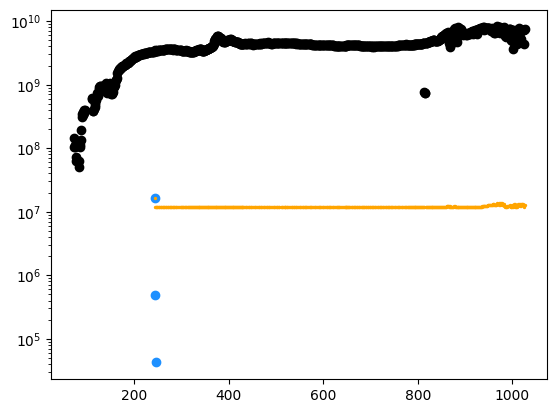

In [10]:
for pair in pairs1:
    branch = stree1[pair['id']]
    tmp = branch['insitu_vir']>0
    if(np.sum(tmp)<5):
        print(np.log10(pair['mstar_vir']), np.log10(pair['mdm_vir']))
        plt.scatter(branch['timestep'], branch['mdm_vir'], fc='k')
        plt.scatter(branch['timestep'], branch['insitu_vir'], fc='dodgerblue')
        plt.scatter(branch['timestep'], branch['mstar_vir'], fc='orange', s=2)
        plt.yscale('log')
        where = np.where(tmp)[0][-1] # first SF epoch
        print(np.log10(np.sum(branch['insitu_vir'])), np.log10(branch[0]['mstar_vir']), branch[where]['timestep'])
        break

In [5]:
target = stree1[pairs1[0]['id']][-1]

In [6]:
snap = snap1s.get_snap(target['timestep'])
snap.set_box_halo(target, 1.5, radius_name='r')
snap.get_cell(nthread=16)
allcells = snap.cell
cells = cut_sphere(allcells, target['x'], target['y'], target['z'], target['r'])

In [7]:
import ramses_function
reload(ramses_function)
from ramses_function import *

In [8]:
# Variable in this snapshot
h0 = params('h0', snap)
aexp = params('aexp', snap)
omega_m = params('omega_m', snap)
scale_nH = params('scale_nH', snap)
nCOM = params('nCOM', snap)
d_gmc = params('d_gmc', snap)
factG = params('factG', snap)
dt_old = params('dt_old', snap)
dt_new = params('dt_new', snap)
mass_sph = params('mass_sph', snap)
localseed = params('localseed', snap)

In [9]:
d_gmc

3707.3446244493675

10.0


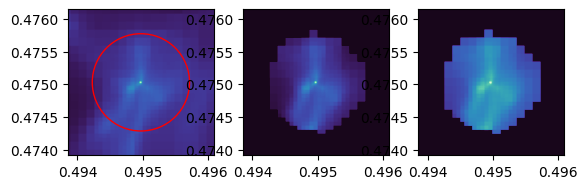

In [10]:
print(d_gmc/snap.unit['H/cc'])
cold = cells[cells['T','K'] < 1e4]
deng = cells[cells['rho','H/cc'] < d_gmc/snap.unit['H/cc']]

fig, axes = plt.subplots(1,3)
painter.draw_gasmap(snap.cell, ax=axes[0])
painter.draw_gasmap(cold, ax=axes[1])
painter.draw_gasmap(deng, ax=axes[2])
cir = plt.Circle((target['x'],target['y']), target['r'], fill=False, color='r')
axes[0].add_artist(cir)

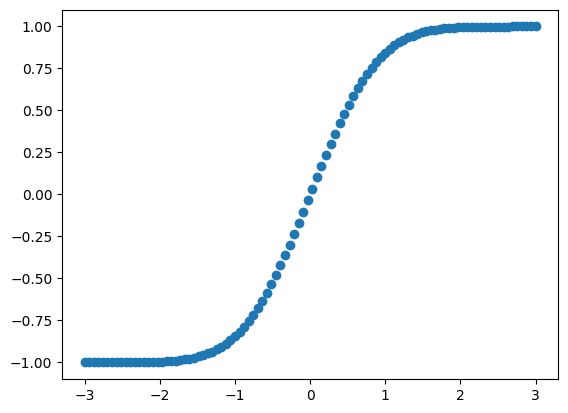

In [11]:
plt.scatter(np.linspace(-3, 3, 100), 1-erfcs(np.linspace(-3, 3, 100)))

In [12]:
def get_dt(snap, snaps):
    istep = np.where(snaps.iout_avail['iout'] == snap.iout)[0][0]
    table = snaps.iout_avail['time']
    return np.abs(table[istep-1] - table[istep])
get_dt(snap, snap1s)

0.1955601350000009

In [219]:
def get_nbor(icell, cells, return_nbor=False, buffer=0.01):
    dx = icell['dx']
    distx = np.abs(cells['x'] - icell['x'])
    disty = np.abs(cells['y'] - icell['y'])
    distz = np.abs(cells['z'] - icell['z'])
    indx = distx <= (dx/2 + cells['dx']/2)
    indy = disty <= (dx/2 + cells['dx']/2)
    indz = distz <= (dx/2 + cells['dx']/2)
    neighs = cells[indx&indy&indz]
    neighs = neighs[neighs['rho'] != icell['rho']]

    samez = (neighs['z'] <= ((icell['z'] + icell['dx']/2)*(1+buffer)))&(neighs['z'] >= ((icell['z'] - icell['dx']/2)*(1+buffer)))
    samey = (neighs['y'] <= ((icell['y'] + icell['dx']/2)*(1+buffer)))&(neighs['y'] >= ((icell['y'] - icell['dx']/2)*(1+buffer)))
    samex = (neighs['x'] <= ((icell['x'] + icell['dx']/2)*(1+buffer)))&(neighs['x'] >= ((icell['x'] - icell['dx']/2)*(1+buffer)))

    # left right
    sameyz = samey & samez
    lrs = neighs[sameyz]
    print(lrs['x'])
    ls = lrs[lrs['x'] < icell['x']]
    rs = lrs[lrs['x'] > icell['x']]
    # front back
    samezx = samez & samex
    fbs = neighs[samezx]
    fs = fbs[fbs['y'] < icell['y']]
    bs = fbs[fbs['y'] > icell['y']]
    # up down
    samexy = samex & samey
    uds = neighs[samexy]
    us = uds[uds['z'] < icell['z']]
    ds = uds[uds['z'] > icell['z']]
    if(return_nbor): return ls, rs, fs, bs, us, ds, neighs
    return ls, rs, fs, bs, us, ds

In [220]:
scale_nH

0.0016327003933974359

In [221]:
localseed = from_raw('localseed', snap, 2)
print(localseed)
localseed = from_raw('localseed', snap1, 1)
print(localseed)
localseed = from_raw('localseed', snap, 1)
print(localseed)
Seed = localseed

[3401 3435 3241 1827]
[3429 3833 3484 3977]
[3281 4041  595 2376]


In [222]:
import ramses_function
reload(ramses_function)
from ramses_function import *

In [235]:
for icell in tqdm(cells):
    if(icell['rho'] < d_gmc*19): continue
    ls,rs,fs,bs,us,ds, neighs = get_nbor(icell, cells, return_nbor=True, buffer=0)
    break
    # print(len(ls), len(rs), len(fs), len(bs), len(us), len(ds))
    # if((len(ls)==0 or len(rs)==0 or len(fs)==0 or len(bs)==0 or len(us)==0 or len(ds)==0)):
    #     print(len(ls), len(rs), len(fs), len(bs), len(us), len(ds), icell['rho'])
        # break
print(icell['rho', 'H/cc'])
ndtype = [
    ('trgv', 'f8'), ('c_s2', 'f8'), ('mach2', 'f8'), 
    ('alpha0', 'f8'), ('sigs', 'f8'), ('scrit', 'f8'), 
    ('sfr_ff', 'f8'), ('tstar', 'f8'), ('mstar', 'f8'), 
    ('nstar', 'i8'), ('dt_fine', 'f8'), ('dt_iout', 'f8'), 
    ('PoissMean', 'f8'), ('nstar_corrected', 'f8')
    ]

# The local 3D instantaneous velocity dispersion sig_g
# trgv = (sig_g)^2
#   trgv = sum( Del (curl) udx )^2
#   `star_formation.f90: federrath3`
trgv = 0
def wmean(vals,ws):
    if(len(vals)==1): return vals[0]
    return np.average(vals, weights=ws)
for val in ['vx','vy','vz']:
    d = icell['rho']
    dl = wmean( ls['rho'], ls['vol'])
    dr = wmean( rs['rho'], rs['vol'])
    df = wmean( fs['rho'], fs['vol'])
    db = wmean( bs['rho'], bs['vol'])
    du = wmean( us['rho'], us['vol'])
    dd = wmean( ds['rho'], ds['vol'])
    vl = ( dl*wmean( ls[val], ls['vol']) + icell[val]*d ) / ( dl + d )
    vr = ( dr*wmean( rs[val], rs['vol']) + icell[val]*d ) / ( dr + d )
    vf = ( df*wmean( fs[val], fs['vol']) + icell[val]*d ) / ( df + d )
    vb = ( db*wmean( bs[val], bs['vol']) + icell[val]*d ) / ( db + d )
    vu = ( du*wmean( us[val], us['vol']) + icell[val]*d ) / ( du + d )
    vd = ( dd*wmean( ds[val], ds['vol']) + icell[val]*d ) / ( dd + d )
    trgv += (vl-vr)**2 + (vf-vb)**2 + (vu-vd)**2
print(f"{trgv=:}")
print(f"{trgv/(snap.unit['km/s'])**2=:}")


# The sound speed squared c_s2
#   `star_formation.f90: federrath3`
# c_s2 = max(smallc**2, icell['P']*(gamma - 1))

# 'cs': lambda table: np.sqrt(gamma * table['P'] / table['rho'])
P = icell['P']
c_s = np.sqrt((gamma-1) * P / d)
print(c_s/snap.unit['km/s'])
c_s2 = c_s**2
print(f"{c_s2=:}")
print(f"{c_s2/(snap.unit['km/s'])**2=:}")

# Mach number
#   mach > 1: highly turbulent regions
mach2 = trgv/c_s2
print(f"{mach2=:}")

# star_formation.f90: 85
#   ! Mesh spacing in that level
ilevel = icell['level']
dx = icell['dx']
dx_loc   = dx
vol_loc = dx_loc**3
mcell = icell['rho'] * vol_loc

# The virial parameter
#   The virial parameter of a spherical gas cloud with the same mass, radius, and thermo-turbulent velocity dispersion of the gas cell
#   alpha0 = 5(trgv + c_s2) / (pi*G*rho*dx_loc**2)
#   alpha < 1 : gravitationally bound
#   `star_formation.f90: federrath3`
alpha0 = 5*(trgv + c_s2)/(np.pi * factG * icell['rho'] * dx_loc**2)
print(f"numerator: {5*(trgv + c_s2)}")
print(f"denominator: {np.pi * factG * icell['rho'] * dx_loc**2}")
print(f"{alpha0=:}")

# Variance of the logarithmic PDF
#   sigs = (sig_s)^2 = ln(1 + b^2 * M^2)
#   b=0.4: fractional amount of solenoidal to compressional modes of the turbulence
#   `star_formation.f90: federrath3`
sigs  = np.log(1.0 + 0.16*mach2)
print(f"{sigs=:}")

# The criitical densisity contrast by Padoan & Nordlund (2011)
#   `star_formation.f90: federrath3`
scrit = np.log(0.067 / theta**2 * alpha0 * mach2)
print(f"{scrit=:}")

# sigs > scrit -> star formation
# Hennebelle & Chabrier (2011)
#   `star_formation.f90: federrath3`
sfr_ff = e_cts/2*phi_t * np.exp(3/8*sigs) * (2 - erfc( (sigs-scrit)/np.sqrt(2*sigs) ))
print(f"{sfr_ff=:}")

# The local free-fall time of the gas
#   `star_formation.f90: federrath3`
tstar     = 0.5427 * np.sqrt(1/( factG*icell['rho'] )) # 0.5427 = sqrt(3pi / 32)


# Initial star particle mass
nlevelmax = snap.params['levelmax']
dx_min   = 0.5**nlevelmax
vol_min  = dx_min**snap.params['ndim']
if(m_star < 0e0): mstar = n_star/(scale_nH*aexp**3)*vol_min*fstar_min
else:
    mass_sph = from_raw('mass_sph', snap)
    mstar=m_star*mass_sph
print(f"{mstar=:}")
print(f"{mcell=:}")

nstar = 0
dt_new = from_raw('dt_new', snap)
dt = dt_new[ilevel-1]
print(dt / snap.unit['Myr'])
dt = get_dt(snap, snap1s)
print(dt / snap.unit['Myr'])
PoissMean = dt*sfr_ff/tstar*mcell/mstar
print(f"{sfr_ff/tstar*mcell/mstar=:}")
print(f"{PoissMean=:}")
# If catastrophic star formation (massive star cluster) wants to occur, we need to limit the 
# maximal mass of the star particle we want to create in a cell.
PoissMean = min(PoissMean,10.0)
print(f"{PoissMean=:}")
# Compute Poisson realisation
localseed = from_raw('localseed', snap)
nstar = poissdev(localseed,PoissMean,nstar)
print(f"{nstar=:}")
# Compute depleted gas mass
mgas      = nstar*mstar

# Security to prevent more than 90% of gas depletion
if (mgas > 0.9*mcell) :
    nstar_corrected = int(0.9*mcell/mstar)
    nstar        = nstar_corrected
print(f"{nstar=:}")





# fig, ax = plt.subplots()
# ax.scatter(neighs['x'], neighs['y'], s=5, c='k')
# for neigh in neighs:
#     rectangle = plt.Rectangle((neigh['x']-neigh['dx']/2, neigh['y']-neigh['dx']/2), neigh['dx'], neigh['dx'], fill=False, color='k', lw=0.2, ls=':')
#     ax.add_patch(rectangle)   
# for tmp in [ls, rs, fs, bs, us, ds]:
#     ax.scatter(tmp['x'], tmp['y'], s=5, c='r')
#     for neigh in tmp:
#         rectangle = plt.Rectangle((neigh['x']-neigh['dx']/2, neigh['y']-neigh['dx']/2), neigh['dx'], neigh['dx'], fill=False, color='r')
#         ax.add_patch(rectangle)
# # rectangle = plt.Rectangle((ls['x']-ls['dx']/2, ls['y']-ls['dx']/2), ls['dx'], ls['dx'], fill=False, color='r')
# # ax.add_patch(rectangle)




# ax.scatter(icell['x'], icell['y'], s=5, c='b')

# ax.set_aspect('equal')

  0%|          | 0/36202 [00:00<?, ?it/s]

[0.4950161  0.49500847]
260.74454015129487
trgv=2.023144853888543e-08
trgv/(snap.unit['km/s'])**2=254.04633000416308
2.602139937473244
c_s2=5.392316186911786e-10
c_s2/(snap.unit['km/s'])**2=6.771132254193257
mach2=37.519032337145106
numerator: 1.0385340078788304e-07
denominator: 1.620971435143146e-08
alpha0=6.4068618691428
sigs=1.946345079308468
scrit=4.996480505728272
sfr_ff=0.00851329077101038
mstar=1.16799952975498e-13
mcell=6.793259489906006e-12
0.0038378197398584485
15.240936287431166
sfr_ff/tstar*mcell/mstar=17.18010635636458
PoissMean=2.370320410230855
PoissMean=2.370320410230855
nstar=3
nstar=3


In [ ]:
np.pi * factG * icell['rho'] * dx_loc**2

1.620971435143146e-08